In [1]:
import numpy as np
import scipy.linalg as LA
from scipy import optimize
from sympy import symbols, diff, Matrix, BlockMatrix, log, exp, lambdify, init_printing
import matplotlib.pyplot as plt

np.seterr(divide='ignore', invalid='ignore');
init_printing()

Miao (2014) より

$$
\begin{aligned}
&
c_t + k_{t+1} - (1 - \delta) k_t = e^{z_t} k_t^\alpha n_t^{1-\alpha}\\
&
\frac{c_{t+1}}{c_t} = \beta\left(
  e^{z_{t+1}} \alpha k_{t+1}^{\alpha - 1} n_{t+1}^{1-\alpha} + 1 - \delta
\right)\\
&
\frac{\chi c_t}{1 - n_t} = (1 - \alpha) e^{z_t} k_t^\alpha n_t^{-\alpha}\\
&
z_{t+1} = \rho z_t + e_{t}
\end{aligned}
$$

$K_0$, $z_0$ は所与

In [2]:
alpha, beta, delta, chi, rho = symbols('alpha beta delta chi rho')
ct, kt, nt, zt, et = symbols('c_t k_t n_t z_t e_t')
ca, ka, na, za = symbols('c_{t+1} k_{t+1} n_{t+1} z_{t+1}')

In [3]:
par = {
    alpha: 0.33, beta: 0.99, delta: 0.023, chi: 1.75, rho: 0.95
}

In [4]:
F = Matrix([
    [ct + ka - (1 - delta) * kt - exp(zt) * kt**alpha * nt**(1 - alpha)],
    [1 / ct - 1 / ca * beta * (exp(za) * alpha * ka **(alpha - 1) * na**(1 - alpha) + 1 - delta)],
    [chi * ct / (1 - nt) - (1 - alpha) * exp(zt) * kt**alpha * nt**(-alpha)],
    [za - rho * zt - et],
])
F

⎡                          α   -α + 1  zₜ                ⎤
⎢     cₜ - kₜ⋅(-δ + 1) - kₜ ⋅nₜ      ⋅ℯ   + k_{t+1}      ⎥
⎢                                                        ⎥
⎢    ⎛         α - 1        -α + 1  z_{t+1}        ⎞     ⎥
⎢  β⋅⎝α⋅k_{t+1}     ⋅n_{t+1}      ⋅ℯ        - δ + 1⎠   1 ⎥
⎢- ───────────────────────────────────────────────── + ──⎥
⎢                       c_{t+1}                        cₜ⎥
⎢                                                        ⎥
⎢              cₜ⋅χ      α   -α           zₜ             ⎥
⎢            ─────── - kₜ ⋅nₜ  ⋅(-α + 1)⋅ℯ               ⎥
⎢            -nₜ + 1                                     ⎥
⎢                                                        ⎥
⎣                  -eₜ - ρ⋅zₜ + z_{t+1}                  ⎦

In [5]:
vt = (zt, kt, ct, nt)
va = (za, ka, ca, na)
exo = (et, )

SSeq = F.subs({k: v for k, v in zip(va, vt)}).subs({k: 0 for k in exo})
SSeq

⎡                          α   -α + 1  zₜ ⎤
⎢cₜ - kₜ⋅(-δ + 1) + kₜ - kₜ ⋅nₜ      ⋅ℯ   ⎥
⎢                                         ⎥
⎢    ⎛    α - 1   -α + 1  zₜ        ⎞     ⎥
⎢  β⋅⎝α⋅kₜ     ⋅nₜ      ⋅ℯ   - δ + 1⎠   1 ⎥
⎢- ────────────────────────────────── + ──⎥
⎢                  cₜ                   cₜ⎥
⎢                                         ⎥
⎢       cₜ⋅χ      α   -α           zₜ     ⎥
⎢     ─────── - kₜ ⋅nₜ  ⋅(-α + 1)⋅ℯ       ⎥
⎢     -nₜ + 1                             ⎥
⎢                                         ⎥
⎣               -ρ⋅zₜ + zₜ                ⎦

In [6]:
fn = lambdify([vt], np.squeeze(SSeq.subs(par)), "numpy")
J = Matrix(BlockMatrix([[diff(SSeq, x) for x in vt]]))
jac = lambdify([vt], J.subs(par), "numpy")

In [7]:
sol = optimize.root(fn, x0=[0, 2, 0.5, 0.5], jac=jac, tol=1e-12)
sol

    fjac: array([[-0.58629553, -0.19178215, -0.78619221,  0.03713443],
       [-0.60101259, -0.5409639 ,  0.58365903,  0.07405443],
       [ 0.5302628 , -0.75453381, -0.1956262 ,  0.33351235],
       [ 0.11774033, -0.3182081 , -0.05453742, -0.93909876]])
     fun: array([-5.55111512e-17,  2.22044605e-16, -8.88178420e-16,  2.06070856e-31])
 message: 'The solution converged.'
    nfev: 23
    njev: 1
     qtf: array([ 6.57058691e-14, -1.49926984e-14, -1.90049203e-14, -5.33351888e-15])
       r: array([ 1.34645918,  0.07473635, -4.14482508, -2.61594154, -0.03747638,
        1.57832579,  3.33142639,  0.11104153, -1.0825533 , -0.22519412])
  status: 1
 success: True
       x: array([4.12141712e-30, 1.02695922e+01, 7.93902032e-01, 3.31892119e-01])

In [8]:
ss = {k:v for k, v in zip(vt, sol.x)}
ss.update({k:v for k, v in zip(va, sol.x)})

In [9]:
DFa = Matrix(BlockMatrix([[diff(F, x) for x in va]]))
A = np.array(DFa.subs(ss).subs(par), dtype=np.float64)
A

array([[ 0.        ,  1.        ,  0.        ,  0.        ],
       [-0.04127713,  0.00269297,  1.58659533, -0.08332732],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 1.        ,  0.        ,  0.        ,  0.        ]])

In [10]:
DFt = Matrix(BlockMatrix([[-diff(F, x) for x in vt]]))
B = np.array(DFt.subs(ss).subs(par), dtype=np.float64)
B

array([[ 1.03010265,  1.01010101, -1.        ,  2.07949733],
       [ 0.        ,  0.        ,  1.58659533,  0.        ],
       [ 2.07949733,  0.06682194, -2.61933746, -5.1801594 ],
       [ 0.95      ,  0.        ,  0.        ,  0.        ]])

In [11]:
DFe = Matrix(BlockMatrix([[-diff(F, x) for x in exo]]))
C = np.array(DFe.subs(ss).subs(par), dtype=np.float64)
C

array([[0.],
       [0.],
       [0.],
       [1.]])

ここで定義した `A`, `B`, `C` は次の動学方程式の係数行列である。

$$
A x_{t+1} = B x_t + C u_t
$$

ただし， $u_t = e_t$ と置き換えた。$x = (x^1, x^2)$, $x^1$ は先決変数，$x^2$ は非先決変数となるように並べておく。適当な条件のもとで, 次の「状態空間表現」に変形できる。

\begin{align}
  x^1_{t+1} &= \Omega_x x_t^1 + \Omega_u u_t + \Omega_y y^u_{t+1}\\
  x^2_t &= \Psi_x x_t^1 + \Psi_y y^u_t
\end{align}

ここで， $y^u_t = y^u(u_t, u_{t+1}, \dots)$ は未来のショックに対する予想を反映して定まる。

係数行列および $y^u_t$ の決め方をおさらいしよう。


$(A,B)$ に対して QZ分解を実行することで，行列ペア $(S, T)$ を作る。

\begin{align}
  Q^* A Z = S\quad Q^* B Z = T
\end{align}


$$
S Z^* x_{t+1} = T Z^* x_t + Q^* C u_t
$$

ここで

$$
y = Z^* x, \qquad U = Q^* C
$$

と置くと，

$$
Sy_{t+1} = T y_t + Uu_t
$$

と書き換えられる。ブロック行列


\begin{align}
Z=
    \begin{bmatrix}
        Z_{1s} & Z_{1u}\\
        Z_{2s} & Z_{2u}
    \end{bmatrix}
    \qquad 
    Q^* C = U = 
    \begin{bmatrix}
        U_s \\
        U_u
    \end{bmatrix}
\end{align}

\begin{align}
S=
    \begin{bmatrix}
        S_{ss} & S_{su}\\
        0 & S_{uu}
    \end{bmatrix}
    \qquad
T=
    \begin{bmatrix}
        T_{ss} & T_{su}\\
        0 & T_{uu}
    \end{bmatrix}
\end{align}


に分解したとき， $S_{ss}^{-1} T_{ss}$ および $T_{uu}^{-1} S_{uu}$ が安定行列になるように一般化固有ベクトルを並べるものとする。


\begin{align}
\Omega_{x} &= Z_{1s}S_{ss}^{-1}T_{ss}Z_{1s}^{-1} \\ 
%
\Omega_u &= Z_{1s}S_{ss}^{-1}\left[
U_{s}-(T_{su}-T_{ss}Z_{1s}^{-1}Z_{1u})T_{uu}^{-1}U_{u}
\right] \\ 
%
\Omega_y &= (Z_{1u}-Z_{1s}S_{ss}^{-1}S_{su})+Z_{1s}S_{ss}^{-1}(T_{su}-T_{ss}Z_{1s}^{-1}Z_{1u})T_{uu}^{-1}S_{uu}
\end{align}


\begin{align}
\Psi_x &= Z_{2s}Z_{1s}^{-1} \\
\Psi_y &= Z_{2u}-Z_{2s}Z_{1s}^{-1}Z_{1u}
\end{align}

In [12]:
from lrem import ordqz, make_slices

def solve_lrem(a, b, c, n1):

    T, S, tii, sii, Q, Z = ordqz(b, a)
    U = Q.T @ c
    ns = sum(abs(tii / sii) <= 1) 
    assert n1 == ns

    _1s, _2s, _1u, _2u, _ss, _su, _su, _uu, _s, _u = make_slices(n1, ns)
    
    Ox = Z[_1s] @ LA.solve(S[_ss], T[_ss]) @ LA.inv(Z[_1s])
    Ou = Z[_1s] @ LA.solve(S[_ss], U[_s] - (T[_su] - T[_ss] @ LA.solve(Z[_1s], Z[_1u]))
                          @ LA.solve(T[_uu], U[_u]))
    Oy = Z[_1u] - Z[_1s] @ LA.solve(S[_ss], S[_su]) + Z[_1s] @ LA.solve(S[_ss],                                                          
            T[_su] - T[_ss] @ LA.solve(Z[_1s], Z[_1u])) @ LA.solve(T[_uu], S[_uu])
    Px = Z[_2s] @ LA.inv(Z[_1s])
    Py = Z[_2u] - Z[_2s] @ LA.solve(Z[_1s], Z[_1u])
    
    
    def yu(u):
        Y = np.zeros((len(u), Oy.shape[1], 1))
        Yplus = np.zeros((Oy.shape[1], 1))
        for i, ut in enumerate(reversed(u)):
            Yplus = LA.solve(T[_uu], S[_uu] @ Yplus - U[_u] @ ut)
            Y[-1-i, :] = Yplus
        return Y

    return Ox, Ou, Oy, Px, Py, yu


Ox, Ou, Oy, Px, Py, yu = solve_lrem(A, B, C, n1=2)

In [13]:
steps = 200

u = np.zeros((steps, 1, 1))
for i in range(10):
    u[i, :] = 0.01

y = yu(u)
x1 = np.zeros((steps, 2, 1))
x2 = np.zeros((steps, 4-2, 1))

for i in range(steps):
    try:
        x1[i+1, :] = Ox @ x1[i, :] + Ou @ u[i, :] + Oy @ y[i+1]
    except IndexError:
        pass
        
    x2[i, :] = Px @ x1[i, :] + Py @ y[i]

x1 = x1.reshape((steps, 2))
x2 = x2.reshape((steps, 2))

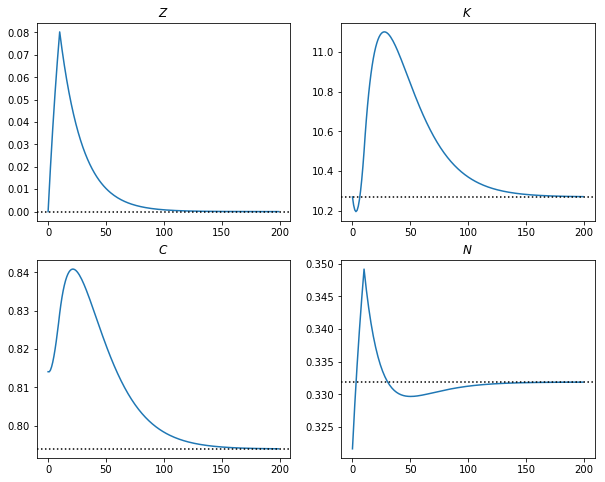

In [14]:
fig, ax = plt.subplots(2, 2)
fig.set_size_inches(10,8)


z, k, c, n = sol.x

ax[0, 0].set_title('$Z$')
ax[0, 0].plot(x1[:, 0])
ax[0, 0].axhline(z, color='black', linestyle='dotted')

ax[0, 1].set_title('$K$')
ax[0, 1].plot(k + x1[:, 1])
ax[0, 1].axhline(k, color='black', linestyle='dotted')

ax[1, 0].set_title('$C$')
ax[1, 0].plot(c + x2[:, 0])
ax[1, 0].axhline(c, color='black', linestyle='dotted')

ax[1, 1].set_title('$N$')
ax[1, 1].plot(n + x2[:, 1])
ax[1, 1].axhline(n, color='black', linestyle='dotted')

plt.show()